## Classifying cells

Here I develop my idea of usinga naive Bayes classfier, with training data created with a simple nearest-neighbor heuristic, to find cells of a type

In [56]:
import numpy as np
import scipy as sp
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
import seaborn
import itertools as it
import h5py
exec( open( "log_progress.py" ).read() )

%load_ext cython

First, load the AnnData object with UMI counts and metadata

In [2]:
cnts = sc.read_h5ad( "Tabula_muris_10x.h5ad" )
cnts

AnnData object with n_obs × n_vars = 55656 × 23433 
    obs: 'tissue', 'channel', 'cell_ontology_class', 'cell_ontology_id', 'channel.y', 'cluster.ids', 'free_annotation', 'mouse.id', 'mouse.sex', 'subsetA', 'subsetA_cluster.ids', 'subsetB', 'subsetB_cluster.ids', 'subtissue', 'tissue_tSNE_1', 'tissue_tSNE_2', 'batch'

The counts are given in a compressed sparse row (CSR) matrix:

In [3]:
cnts.X.__class__

scipy.sparse.csr.csr_matrix

This is good to quickly get expression vectors for cells but not to get expression of one gene for all cells, as we need next. Luckily, Scanpy allows to simply transpose the whole thing:

In [4]:
cntsT = cnts.transpose()
cntsT

AnnData object with n_obs × n_vars = 23433 × 55656 
    var: 'tissue', 'channel', 'cell_ontology_class', 'cell_ontology_id', 'channel.y', 'cluster.ids', 'free_annotation', 'mouse.id', 'mouse.sex', 'subsetA', 'subsetA_cluster.ids', 'subsetB', 'subsetB_cluster.ids', 'subtissue', 'tissue_tSNE_1', 'tissue_tSNE_2', 'batch'

My test case will be endothelial cells (inner lining of blood vessels). These cells appear in most of the tissues, which makes them interesting. In the Tabula muris tissue supplement, they used different markers depending on tissue, but nearly always included Pecam1 (a.k.a. CD31), a protein found on the surface of endothelial cells as well as various blood cells and for Cadherin-5 (Cdh5, CD144). I am not quite sure yet whether these two markers are together sufficiently specific to catch only endothelial cells, but for now I will assume so. 

I select cells with more than minimal expression of the two markers, and call these my "gold-standard" endothelial cells.

In [5]:
cnts.obs["endo_gold"] = ( cntsT["Pecam1",:].X > 3 ) & ( cntsT["Cdh5",:].X > 3 )

Here is a scatter plot of these two markers.

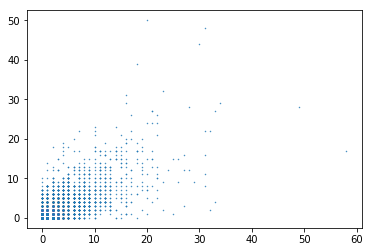

In [144]:
plt.scatter( cntsT["Pecam1",:].X, cntsT["Cdh5",:].X, s=.2 )

I check what cell types the Tabula muris authors have assigned in their Seurat-based analysis to the cells that I have just picked as "gold" endothelial cells.

In [7]:
cnts[ cnts.obs.endo_gold, : ].obs.cell_ontology_class.value_counts()

endothelial cell                        612
lung endothelial cell                   193
kidney capillary endothelial cell        72
endocardial cell                         29
macrophage                                2
stromal cell                              1
myeloid cell                              1
mesenchymal stem cell                     1
leukocyte                                 1
endothelial cell of hepatic sinusoid      1
Name: cell_ontology_class, dtype: int64

This seems to have worked quite well so far. (Note that the endocardium is simply the endothelium of the heart, i.e., these are endothelial cells, too.) Only 6 false positives in 915 cells. And maybe these aren't false, either, but were wrongly classified in the Seurat analysis.

However, we have probably missed many endothelial cells where the sequencing has failed to detect the two marker genes. The idea is now that we can probably still recognize them as being intermixed between the gold endothelial cells.

Hence, I open the similarity score matrix file, that I have created in 

In [8]:
h5f = h5py.File( "sims.hdf5", "r" )
h5sim = h5f["sim_matrix"]

As a preparation, I find for each cell its *k*=20 nearest neighbors, storing this in an array `nn`. This can be done quickly, in less than a minute, thanks to numpy's `argpartition` function, which allows me to bring the *k* smallest distances to the front and then sort only them.

Afterwars `nn[i,j]` contains the index (row number in `cnts.X`) of the $(j+1)$-th nearest neighbor of the cell with index $i$, i.e., column 0 contains the nearest, column 1 the next-to-nearest neighbors etc.

In [9]:
k = 20
nn = np.empty( ( cnts.n_obs, k ), 'i' )
for i in log_progress( range(cnts.n_obs) ):
    a = -h5sim[ i, : ]
    argpart = a.argpartition(k+1)[:(k+1)]
    nn[i,:] = argpart[ a[argpart].argsort() ][1:]


I use this now to count for each cell how many of its 10 nearest neighbors are among the "gold endothelial" cells.

In [10]:
a = np.full( (cnts.n_obs,), -1 )
for i in log_progress( range(cnts.n_obs) ):
    a[i] = cnts.obs.endo_gold[ nn[i,:10] ].sum()
cnts.obs["n_endo_gold_nghbrs"] = a        

Let's make a histogram of these values, with stacked bars splitting by cells that are themselves endo-gold (orange) and the others (blue).

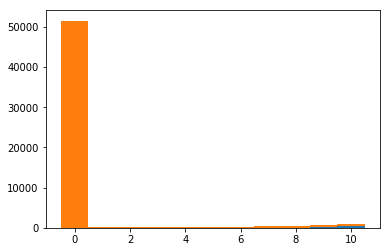

In [11]:
plt.hist( 
    [ cnts[  cnts.obs.endo_gold ].obs.n_endo_gold_nghbrs, 
      cnts[ ~cnts.obs.endo_gold ].obs.n_endo_gold_nghbrs  ],
    stacked=True, bins=np.arange(-.5,11.5) );

Zoom in on the y axis.

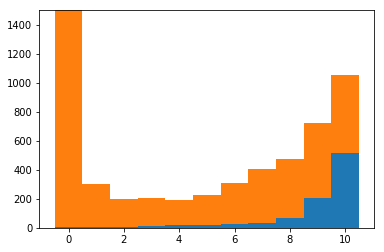

In [12]:
plt.hist( 
    [ cnts[  cnts.obs.endo_gold, : ].obs.n_endo_gold_nghbrs, 
      cnts[ ~cnts.obs.endo_gold, : ].obs.n_endo_gold_nghbrs  ],
    stacked=True, bins=np.arange(-.5,11.5) );
plt.ylim(0,1500);

Let's define "endo gold-negative cells" as those which neither express any markers of the two nor have any endo golds among their 10 nearest neighbors.

In [13]:
cnts.obs["endo_gold_neg"] = ( cntsT["Pecam1",:].X == 0 ) & ( cntsT["Cdh5",:].X == 0 ) & \
  ( cnts.obs.n_endo_gold_nghbrs == 0 )

cnts.obs.endo_gold_neg.sum()

46574

Get the expression values via square root and L2-nomalization, as used in the distance calculation.

In [14]:
exprs = cnts.copy()
exprs.X = sp.sparse.vstack( np.sqrt( cnts.X[i,:] ) / np.sqrt( cnts.X[i,:].sum() ) 
             for i in log_progress( range(cnts.n_obs) ) )

Here is utility function that takes the row number or index label of an observation ("cell") in an AnnData object and returns a Pandas Series vector with the expression values of this cell for all genes.

In [145]:
def get_dense_obs( anndata, obs ):
    ans = pd.Series( 0, anndata.var.index, name = obs)
    if not isinstance( obs, int ):
        obs = anndata.obs.index.get_loc( obs )
    indptr_from = anndata.X.indptr[ obs ]
    indptr_to   = anndata.X.indptr[ obs+1 ]
    ans[ anndata.X.indices[ indptr_from : indptr_to ] ] = \
       anndata.X.data[ indptr_from : indptr_to ] 
    return ans

Get means and SDs of the endo gold-positive and gold-negative cells. (This is quite slow; I should maybe use write something in Cython here.)

In [146]:
exprsT = exprs.transpose()

In [161]:
endo_params = pd.DataFrame( index = exprs.var.index, dtype="f",
        columns = [ "pos_mean", "pos_sd", "neg_mean", "neg_sd" ] )

for i in log_progress( exprs.var.index ):
    x = get_dense_obs( exprsT, i )
    endo_params.pos_mean[i] = np.mean( x[ exprs.obs.endo_gold ] )
    endo_params.pos_sd  [i] = np.std ( x[ exprs.obs.endo_gold ] )
    endo_params.neg_mean[i] = np.mean( x[ exprs.obs.endo_gold_neg ] )
    endo_params.neg_sd  [i] = np.std ( x[ exprs.obs.endo_gold_neg ] )
    
endo_params

,pos_mean,pos_sd,neg_mean,neg_sd
index,,,,
Xkr4,0.000000,0.000000,6.391235e-06,0.000259
Rp1,0.000010,0.000297,9.353284e-06,0.000352
Sox17,0.012669,0.014307,4.312611e-05,0.000789
Mrpl15,0.003787,0.006421,3.856614e-03,0.006474
Lypla1,0.004072,0.006510,3.628493e-03,0.006425
Tcea1,0.006367,0.007519,5.311561e-03,0.007339
Rgs20,0.000009,0.000274,5.946376e-05,0.000704
Atp6v1h,0.002595,0.005189,1.829227e-03,0.004630
Oprk1,0.000011,0.000339,2.259150e-06,0.000138


Let's calculate a separation score, showing for each gene $i$ by how many standard deviations the mean values for positive and negative training cells are separated: $z_i^* = \frac{ \mu_i^\text{p} - \mu_i^\text{n} }{ \sigma_i^\text{p} + \sigma_i^\text{n} }$

In [162]:
endo_params["sep_score"] = ( endo_params.pos_mean - endo_params.neg_mean ) /   \
   ( endo_params.pos_sd + endo_params.neg_sd )

Here is a histogram of these scores:

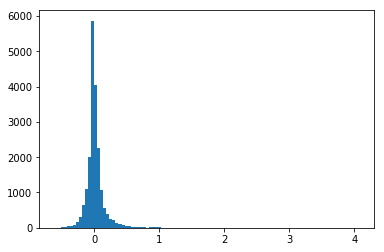

In [163]:
x =  np.asarray( endo_params.sep_score, dtype="f" )
plt.hist( x[ ~np.isnan(x) ], 100 );

Let's sort the parameter table by the separation scores to see the top markers for negative and positive endothelial training cells, respectively.

In [165]:
endo_params[ ~np.isnan(endo_params.sep_score) ].sort_values("sep_score")

,pos_mean,pos_sd,neg_mean,neg_sd,sep_score
index,,,,,
Rpsa,0.029553,0.011716,0.048299,0.018967,-0.610964
Rpl10a,0.028262,0.011648,0.045402,0.018680,-0.565130
Rps3a,0.041556,0.012336,0.060441,0.021120,-0.564472
Rpl12,0.024935,0.012059,0.042536,0.019946,-0.549959
Sdc4,0.002296,0.005817,0.016341,0.019884,-0.546472
Rplp0,0.045371,0.015702,0.069174,0.028819,-0.534625
Ly6d,0.001013,0.003552,0.017355,0.027103,-0.533068
Rpl11,0.037909,0.010587,0.052865,0.017634,-0.529976
Rpl13a,0.051367,0.014225,0.072957,0.026838,-0.525787


Note how the top positive genes are all indeed genes known to be specific for vascular endothelium. 

#### Naive Bayes classifier

If I now have a new cell and know that its expression for gene $i$ is $y_i$, then I can simply calculate the Bayes factor for it being an endothelial cell (positive, "P") or not (negative, "N") as the ratio of the probabilties to get the value $y_i$ from the normal probability densities associated with the means and SDs just calculated: 

  $\text{BF}_i = \frac{f_\cal{N}(y_i|\mu_i^\text{p}, \sigma_i^\text{p})}{f_\cal{N}(y_i|\mu_i^\text{n}, \sigma_i^\text{n})},$

where I have written $f_\cal{N}(y|\mu,\sigma)$ for the probability density of observing $y$ in a normal with mean $\mu$ and standard deviation $\sigma$: 

  $f_\cal{N}(y|\mu,\sigma) = \frac{1}{\sqrt{2\pi}\sigma} \exp\frac{(y-\mu)^2}{2\sigma^2}$

The idea of a so-called naive Bayes classifier is to multiply these Bayes factors for all genes, and so get an overall Bayes factor. Of course, this will not yield a correct Bayes factor, because the genes are correlated, but the idea of naive Bayes classification is that it is permissible to ignore this issue and the result will still be a useful classification score.

We will work with logarithmic Bayes factors (LBF):

  $\text{LBF}_i = \ln \text{BF}_i = 
     \frac{1}{2}\left(\frac{y_i - \mu^\text{p}_i}{\sigma^\text{p}_i}\right)^2 -
     \frac{1}{2}\left(\frac{y_i - \mu^\text{n}_i}{\sigma^\text{n}_i}\right)^2 - 
     \ln \sigma^\text{p}_i + \ln \sigma^\text{n}_i$
     
For a given cell with expression values $y_i$, the classifier score is hence the sum $\sum_i \text{LBF}_i$. If the score is positive, it is called an endothlial cell; if it is negative it is called not endothelial.

One issue here is that many standard deviations are zero, which happens, when all $n$ cells in one class of our training data have expression 0 for a given gene. Then any cell with even minute expression of this gene would get an infinite LBF, i.e., the classifier would consider it impossible that this cell is of the class. Following "Cromwell's rule", such definiteness should be avoided, and hence I replace the zeros with small positive numbers.

[ *ignore*: I invoke the rule of succession, as follows: If we had one more cell, maybe this $(n+1)$-th cell would have shown some expression $\tilde y$, and then the standard deviation would have turned out to be $\tilde y / \sqrt{n+1}$. ]

For now, I use an arbitrary small number, 0.0003, chosen to be a few times the value of the smallest nonzero SDs.:

In [167]:
endo_params.pos_sd[ endo_params.pos_sd>0 ].min()

0.00014434678

In [168]:
endo_params.pos_sd = np.maximum( endo_params.pos_sd, .0003 )
endo_params.neg_sd = np.maximum( endo_params.neg_sd, .0003 )

Now, I calculate the classifier scores, first ony for the first 1000 cells because it is quite slow.

In [183]:
%%time 
class_scores_0 = np.zeros( (1000,) )
for i in log_progress( range(1000) ):
    x = get_dense_obs( exprs, i )
    class_scores_0[i] = \
       sp.stats.norm.logpdf( x, endo_params.pos_mean, endo_params.pos_sd ).sum() - \
       sp.stats.norm.logpdf( x, endo_params.neg_mean, endo_params.neg_sd ).sum() 

CPU times: user 4.18 s, sys: 23.7 ms, total: 4.2 s
Wall time: 4.16 s


To do this for all 55k cells would take around 5 min. 

That might be ok, but we can get much faster by using Cython. Here my try.

In [190]:
%%cython 
import numpy as np
cimport numpy as np

def naivebayes( exprs, trained_params ):

    cdef int i, j, ind_from, ind_to, ip
    cdef int n_var = exprs.n_vars
    
    cdef np.float_t lbf, ap, an
    
    cdef int[:] indptr = exprs.X.indptr
    cdef int[:] indices = exprs.X.indices
    cdef np.float_t[:] data = exprs.X.data

    cdef float[:] pos_mean = trained_params.pos_mean.values
    cdef float[:] pos_sd   = trained_params.pos_sd.values
    cdef float[:] neg_mean = trained_params.neg_mean.values
    cdef float[:] neg_sd   = trained_params.neg_sd.values
    
    ans_np = np.zeros( (exprs.n_obs,) )
    cdef np.float_t[:] ans = ans_np
    
    cdef float norm_term =  \
      np.log( trained_params.pos_sd.values ).sum() -  \
      np.log( trained_params.neg_sd.values ).sum()

    for i in range(exprs.n_obs):

        ind_from  = indptr[i]
        ind_to    = indptr[i+1]
        ip = ind_from
        lbf = 0
        
        for j in range( n_var ):
            
            ap = pos_mean[j]
            an = neg_mean[j]
            if ip < ind_to and indices[ip] == j:
                ap -= data[ip]
                an -= data[ip]
                ip += 1
            ap /= pos_sd[j]
            an /= neg_sd[j]
            lbf += ( ap * ap - an * an ) / (-2)
        
        ans[i] = lbf - norm_term   
        
        if i % 1000 == 0:
            print(i // 1000, end=" ")
 
    print()
    return ans_np

In [191]:
%%time 
class_scores = naivebayes( exprs, endo_params )

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 
CPU times: user 7.69 s, sys: 0 ns, total: 7.69 s
Wall time: 7.68 s


Check whether the two scores are the same:

In [193]:
class_scores_0 - class_scores[:1000]

array([0.01288557, 0.01288557, 0.01288557, 0.01288557, 0.01288557,
       0.01288557, 0.01288557, 0.01288557, 0.01288557, 0.01288557,
       0.01288557, 0.01288557, 0.01288557, 0.01288557, 0.01288557,
       0.01288557, 0.01288557, 0.01288557, 0.01288557, 0.01288557,
       0.01288557, 0.01288557, 0.01288557, 0.01288557, 0.01288557,
       0.01288557, 0.01288557, 0.01288557, 0.01288557, 0.01288557,
       0.01288557, 0.01288557, 0.01288557, 0.01288557, 0.01288557,
       0.01288557, 0.01288557, 0.01288557, 0.01288557, 0.01288557,
       0.01288557, 0.01288557, 0.01288557, 0.01288557, 0.01288557,
       0.01288557, 0.01288557, 0.01288557, 0.01288557, 0.01288557,
       0.01288557, 0.01288557, 0.01288557, 0.01288557, 0.01288557,
       0.01288557, 0.01288557, 0.01288557, 0.01288557, 0.01288557,
       0.01288557, 0.01288557, 0.01288557, 0.01288557, 0.01288557,
       0.01288557, 0.01288557, 0.01288557, 0.01288557, 0.01288557,
       0.01288557, 0.01288557, 0.01288557, 0.01288557, 0.01288

Well, nearly. But given that the scores go into the thousands, this might be some rounding error in the normalization term.

Here is a histogram of the scores

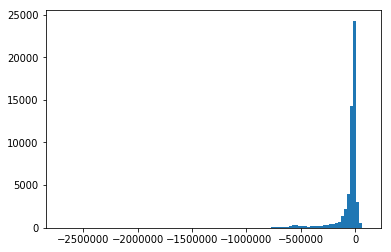

In [197]:
plt.hist( class_scores, 100 );

Zoom in

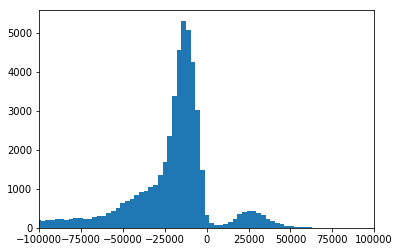

In [198]:
plt.hist( class_scores, 1000 )
plt.xlim( -100000,100000);

Zoom in even more on the decision boundary

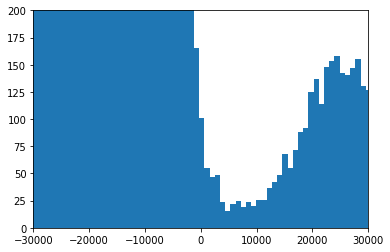

In [199]:
plt.hist( class_scores, 3000 )
plt.xlim( -30000, 30000); plt.ylim( 0, 200 );

In [223]:
exprs.obs["gold"] = "no"
exprs.obs.gold.values[ exprs.obs.endo_gold ] = "pos"
exprs.obs.gold.values[ exprs.obs.endo_gold_neg ] = "neg"

Plot scores against total UMI count of the cells

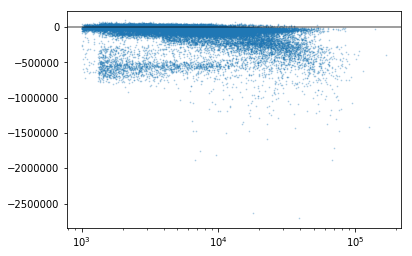

In [235]:
plt.scatter( 
    np.asarray(cnts.X.sum(axis=1)).flatten(), 
    class_scores, 
    s = .5, alpha = .3 )
plt.xscale("log")

#plt.ylim( -500000,100000)
plt.axhline( 0, 0, 1, color="black", alpha=.5 );

Zoom in, use colors: orange for training positives, turquoise for training negatives

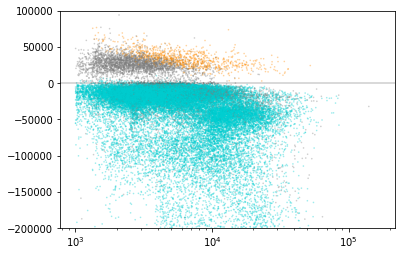

In [231]:
plt.scatter( 
    np.asarray(cnts.X.sum(axis=1)).flatten(), 
    class_scores, 
    c = [ "darkorange" if x=="pos" else "darkturquoise" if x=="neg" else "gray" 
            for x in exprs.obs.gold.values ],
    s=.5, alpha=.3 )
plt.xscale("log")

plt.ylim( -200000,100000)
plt.axhline( 0, 0, 1, color="black", alpha=.2 );

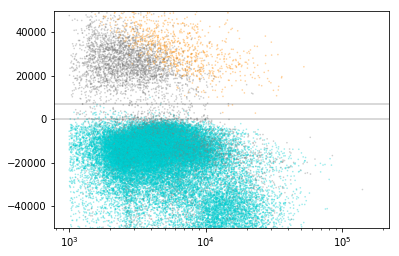

In [240]:
plt.scatter( 
    np.asarray(cnts.X.sum(axis=1)).flatten(), 
    class_scores, 
    c = [ "darkorange" if x=="pos" else "darkturquoise" if x=="neg" else "gray" 
            for x in exprs.obs.gold.values ],
    s=.5, alpha=.3 )
plt.xscale("log")

plt.ylim( -50000,50000)
plt.axhline( 0, 0, 1, color="black", alpha=.2 );
plt.axhline( 7000, 0, 1, color="black", alpha=.2 );

Compare the three score ranges indicated with gray bars with the original annotation

In [243]:
pd.crosstab( 
    exprs.obs.cell_ontology_class, 
    [ a > 0, a > 7000 ],
    colnames=[ ">0", ">7000" ] ).sort_values( ( True, True ), ascending=False )

>0                                                 False True       
>7000                                              False False True 
cell_ontology_class                                                 
endothelial cell                                      67    74  2702
lung endothelial cell                                  7    21   434
kidney capillary endothelial cell                      7     8   377
endocardial cell                                       0     1    62
stromal cell                                        3224    12     4
leukocyte                                            243     4     4
kidney collecting duct epithelial cell               439     1     3
endothelial cell of hepatic sinusoid                  24     2     2
mesenchymal stem cell                               1130     5     1
macrophage                                          1317     2     1
mesangial cell                                        48     2     1
neuroendocrine cell                                  353     8     1
B cell                                              8291     3     0
luminal epithelial cell of mammary gland             459     0     0
kidney proximal straight tubule epithelial cell     1198     0     0
kidney loop of Henle ascending limb epithelial ...   471     0     0
kidney cell                                           45     0     0
late pro-B cell                                      265     0     0
mast cell                                             24     0     0
immature T cell                                     1354     0     0
mesenchymal cell                                    7848     0     0
monocyte                                             525     0     0
myeloid cell                                          87     0     0
natural killer cell                                 1096     0     0
non-classical monocyte                               219     1     0
proerythroblast                                      265     0     0
professional antigen presenting cell                  31     0     0
promonocyte                                          257     0     0
skeletal muscle satellite cell                       354     0     0
keratinocyte                                        3076     0     0
hepatocyte                                          1764     0     0
immature B cell                                      113     0     0
DN1 thymic pro-T cell                                 44     0     0
Fraction A pre-pro B cell                             66     0     0
Langerhans cell                                       38     0     0
T cell                                              4406     3     0
alveolar macrophage                                  345     0     0
basal cell                                           392     0     0
basal cell of epidermis                             4424     0     0
basophil                                              61     0     0
bladder cell                                        1203     0     0
bladder urothelial cell                             1167     0     0
blood cell                                          1139     0     0
cardiac muscle cell                                   60     0     0
ciliated columnar cell of tracheobronchial tree       49     0     0
classical monocyte                                   161     0     0
dendritic cell                                        42     0     0
duct epithelial cell                                  27     0     0
early pro-B cell                                      65     0     0
epithelial cell                                      892     0     0
erythroblast                                         155     0     0
erythrocyte                                           81     0     0
fibroblast                                           226     0     0
granulocyte                                          725     0     0
granulocytopoietic cell                              378     0     

Finally, how does the score correlate with the number of gold endothlial neighbors

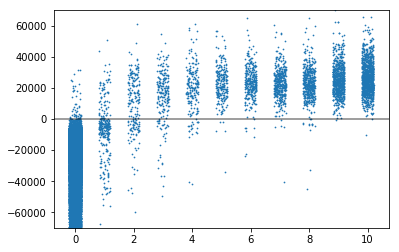

In [299]:
plt.scatter( exprs.obs.n_endo_gold_nghbrs + np.random.uniform( -.2, .2, exprs.n_obs) , a, s=.5 )
plt.ylim( -70000, 70000 )
plt.axhline( 0, 0, 1, color="black", alpha=.5 )

-------
-------

From here on junk (experimental stuff I didn't know where else to put):

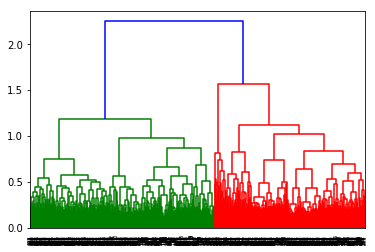

In [29]:
a = h5sim[ cnts.obs.endo_gold, : ][ : , cnts.obs.endo_gold ]
cl = sp.cluster.hierarchy.complete( np.sqrt( 1 - a/2 ) ) 
sp.cluster.hierarchy.dendrogram( cl );

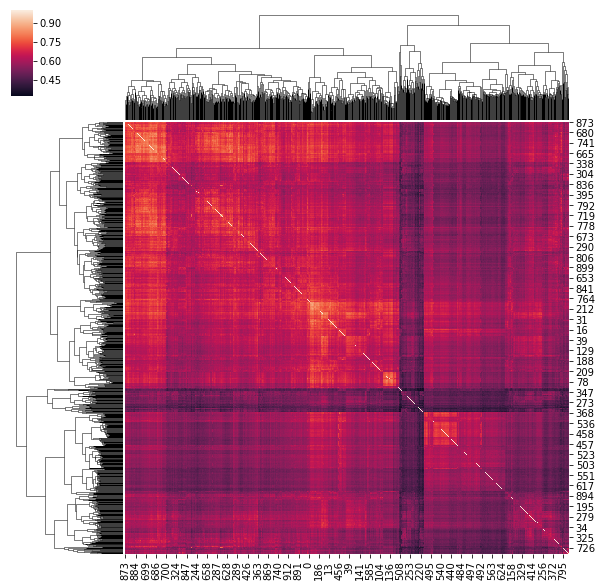

In [25]:
seaborn.clustermap( h5sim[ cnts.obs.endo_gold, : ][ : , cnts.obs.endo_gold ] );